In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import librosa

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from preprocess import split_data, scale, unroll_sequence
from evaluate import evaluate_predictions, plot_history
from utils.constants import DATA_DIR, PROCESSED_DATA, SEED

2024-05-15 13:02:38.692000: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 13:02:38.693874: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 13:02:39.295452: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-15 13:02:40.298210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 13:02:43.981917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
random.seed(SEED)
np.random.seed(SEED)
sklearn.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
## Important Params
SEGMENT_NUM = 5

split_precentages = {
    'train': 0.7,
    'valid': 0.15,
    'test': 0.15
}

In [4]:
## load processed data

# load aggregated data (for logreg and RF)
file_name = f'{SEGMENT_NUM}_data.npz'
file_path = os.path.join(DATA_DIR, 'processed_data')
npzfile = np.load(os.path.join(file_path, file_name))
print(npzfile.files)

X_agg = npzfile['X']
Y_agg = npzfile['Y']

['X', 'Y']


In [5]:
# load mfcc and mel data (for LSTM and CNN)
file_name = f'{SEGMENT_NUM}_data_parts.npz'
file_path = os.path.join(DATA_DIR, 'processed_data')
npzfile = np.load(os.path.join(file_path, file_name))
print(npzfile.files)

X_mfcc = npzfile['mfcc']
X_mel = npzfile['mel']
Y_mfcc_mel = npzfile['labels']

['labels', 'mfcc', 'mel']


## Preprocess Data

In [6]:
## Split Data
X_agg_train, X_agg_valid, X_agg_test, Y_agg_train, Y_agg_valid, Y_agg_test = split_data(X_agg, Y_agg, split_precentages)
X_mfcc_train, X_mfcc_valid, X_mfcc_test, Y_mfcc_train, Y_mfcc_valid, Y_mfcc_test = split_data(X_mfcc, Y_mfcc_mel, split_precentages)
X_mel_train, X_mel_valid, X_mel_test, _, _, _ = split_data(X_mel, Y_mfcc_mel, split_precentages)

print('X_agg_train shape: ', X_agg_train.shape)
print('X_mfcc_train shape: ', X_mfcc_train.shape)
print('X_mel_train shape: ', X_mel_train.shape)

X_agg_train shape:  (699, 1, 37)
X_mfcc_train shape:  (698, 1291, 13)
X_mel_train shape:  (698, 1291, 128)


In [7]:
## Scale with the maximum value
X_agg_train, X_agg_valid, X_agg_test = scale(X_agg_train, X_agg_valid, X_agg_test)
X_mfcc_train, X_mfcc_valid, X_mfcc_test = scale(X_mfcc_train, X_mfcc_valid, X_mfcc_test)
X_mel_train, X_mel_valid, X_mel_test = scale(X_mel_train, X_mel_valid, X_mel_test)

In [8]:
## Reshape - we also have to reshape the spectograms for the CNN
X_mel_train = X_mel_train.reshape((X_mel_train.shape[0], X_mel_train.shape[1], X_mel_train.shape[2], 1))
X_mel_valid = X_mel_valid.reshape((X_mel_valid.shape[0], X_mel_valid.shape[1], X_mel_valid.shape[2], 1))
X_mel_test = X_mel_test.reshape((X_mel_test.shape[0], X_mel_test.shape[1], X_mel_test.shape[2], 1))

print('X_mel_train shape: ', X_mel_train.shape)

X_mel_train shape:  (698, 1291, 128, 1)


In [9]:
## Converting labels into a vector
genres = 10
genre_list = np.unique(Y_agg)

Y_agg_train = to_categorical(Y_agg_train, genres)
Y_agg_valid = to_categorical(Y_agg_valid, genres)
Y_agg_test = to_categorical(Y_agg_test, genres)

Y_mfcc_train = to_categorical(Y_mfcc_train, genres)
Y_mfcc_valid = to_categorical(Y_mfcc_valid, genres)
Y_mfcc_test = to_categorical(Y_mfcc_test, genres)

print('Y_agg_train shape: ', Y_agg_train.shape)

Y_agg_train shape:  (699, 10)


In [10]:
## Unroll segments
# if we are using segmented data, then we have to unroll them for LogReg and RF
X_train_unrolled, Y_train_unrolled = unroll_sequence(X_agg_train, Y_agg_train) 
X_valid_unrolled, Y_valid_unrolled = unroll_sequence(X_agg_valid, Y_agg_valid) 
X_test_unrolled, Y_test_unrolled = unroll_sequence(X_agg_test, Y_agg_test) 

print('X_train_unrolled shape: ', X_train_unrolled.shape)
print('Y_train_unrolled shape: ', Y_train_unrolled.shape)

X_train_unrolled shape:  (699, 37)
Y_train_unrolled shape:  (699, 10)


## Model training

In [11]:
from sklearn.linear_model import LogisticRegression

MAX_ITER = 10_000

logreg_model = LogisticRegression(max_iter=MAX_ITER, verbose=0)
logreg_model.fit(X_train_unrolled, Y_train_unrolled.argmax(axis=1))

LogisticRegression(max_iter=10000)

In [12]:
from sklearn.ensemble import RandomForestClassifier

N_ESTIMATORS = 200
MAX_DEPTH = 8

rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
rf.fit(X_train_unrolled, Y_train_unrolled.argmax(axis=1))

RandomForestClassifier(max_depth=8, n_estimators=200)

In [13]:
## general for all other models

BATCH_SIZE = 32

es = EarlyStopping(
    patience=10, 
    restore_best_weights=True, 
    start_from_epoch=5)
callbacks = [es]

In [14]:
## LSTM
LSTM_model = Sequential([
    LSTM(128, dropout=0.0, recurrent_dropout=0.0, return_sequences=True),
    BatchNormalization(),
    LSTM(64, dropout=0.0, recurrent_dropout=0.0),
    BatchNormalization(),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(10, activation="softmax")
])

LSTM_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 886ms/step - accuracy: 0.1631 - loss: 2.4674 - val_accuracy: 0.1477 - val_loss: 2.2733
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 893ms/step - accuracy: 0.3292 - loss: 1.9176 - val_accuracy: 0.1879 - val_loss: 2.2589
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 840ms/step - accuracy: 0.3662 - loss: 1.8349 - val_accuracy: 0.1409 - val_loss: 2.2551
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 821ms/step - accuracy: 0.4169 - loss: 1.6502 - val_accuracy: 0.1879 - val_loss: 2.2482
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 853ms/step - accuracy: 0.4543 - loss: 1.5522 - val_accuracy: 0.1879 - val_loss: 2.2368
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 850ms/step - accuracy: 0.4905 - loss: 1.4998 - val_accuracy: 0.1208 - val_loss: 2.2291
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 809ms/step - accuracy: 0.4932 - loss: 1.4736 - val_accuracy: 0.1745 - val_loss: 2.2077
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 798ms/step - accuracy: 0.4980 - loss: 1.4059 - 

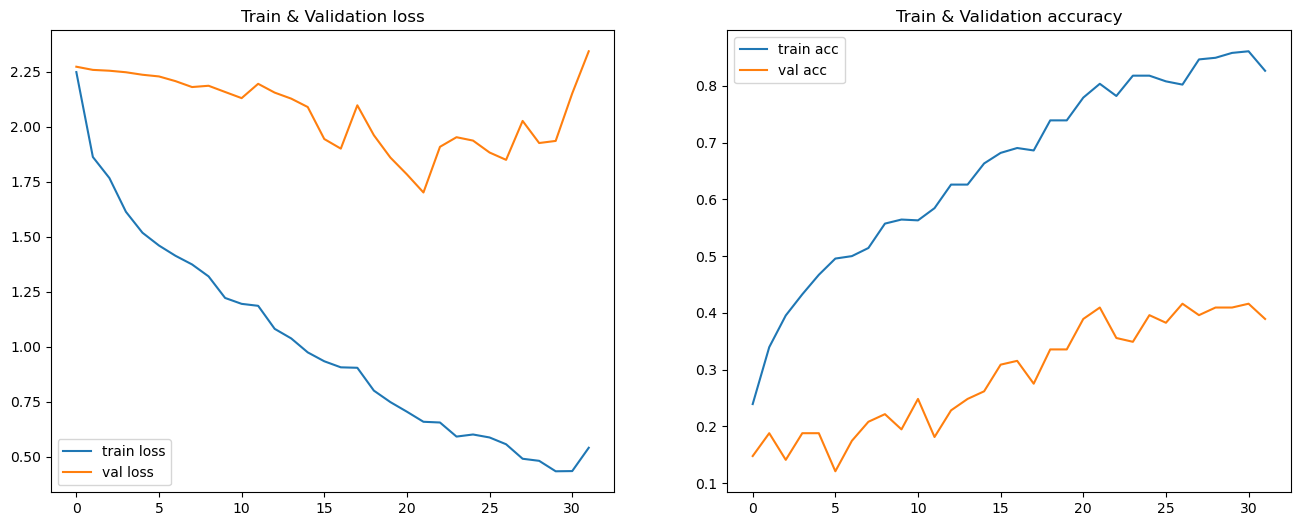

In [15]:
EPOCHS = 200

history = LSTM_model.fit(
    X_mfcc_train, Y_mfcc_train.argmax(axis=1).reshape(-1,1), 
    validation_data=(X_mfcc_valid, Y_mfcc_valid.argmax(axis=1).reshape(-1,1)),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

fig = plot_history(history)

In [16]:
# CNN model
CNN_model = Sequential([
    Conv2D(8, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Conv2D(16, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((4,4), padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.1152 - loss: 2.3031 - val_accuracy: 0.1275 - val_loss: 2.2832
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.1745 - loss: 2.2443 - val_accuracy: 0.2148 - val_loss: 2.0415
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.2334 - loss: 2.0488 - val_accuracy: 0.2953 - val_loss: 1.8610
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.2812 - loss: 1.8973 - val_accuracy: 0.3154 - val_loss: 1.7210
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.3324 - loss: 1.7923 - val_accuracy: 0.3423 - val_loss: 1.6493
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.3200 - loss: 1.7493 - val_accuracy: 0.3826 - val_loss: 1.6042
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.3518 - loss: 1.6930 - val_accuracy: 0.4027 - val_loss: 1.5423
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.3850 - loss: 1.6576 - val_accu

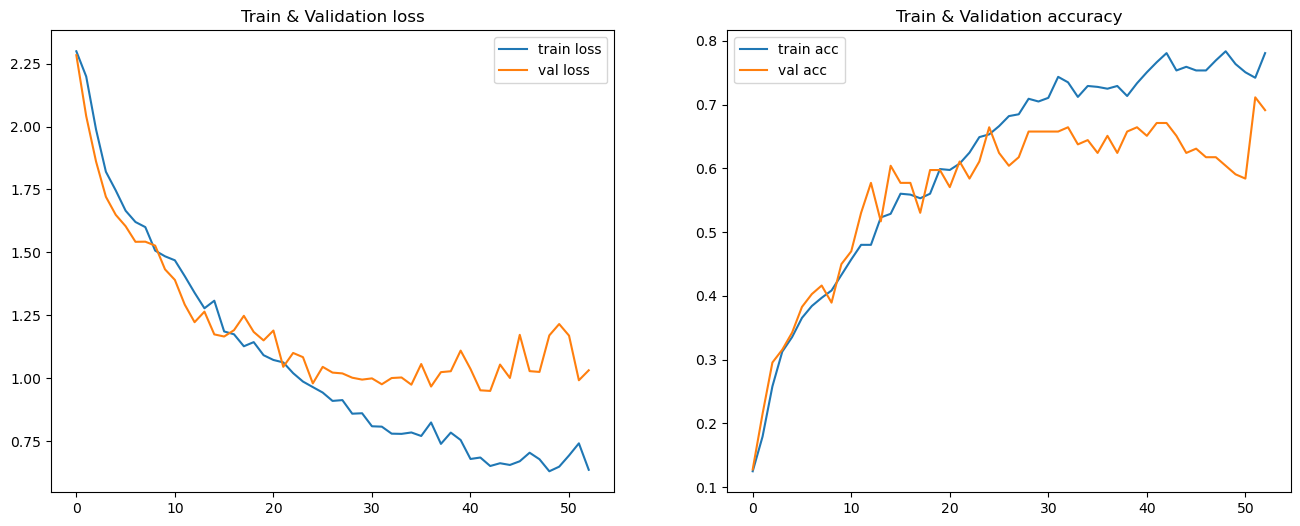

In [17]:
EPOCHS = 200

history = CNN_model.fit(
    X_mel_train, Y_mfcc_train.argmax(axis=1).reshape(-1,1),
    validation_data=(X_mel_valid, Y_mfcc_valid.argmax(axis=1).reshape(-1,1)),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

fig = plot_history(history)

## Evaluation

In [18]:
# getting true labels for the test sets
Y_agg_true = Y_agg_test.argmax(axis=1)
Y_agg_true_unrolled = Y_test_unrolled.argmax(axis=1)
Y_mfcc_true = Y_mfcc_test.argmax(axis=1)

In [19]:
# predictions
Y_pred_logreg = logreg_model.predict(X_test_unrolled)
Y_pred_rf = rf.predict(X_test_unrolled)
Y_pred_lstm = LSTM_model.predict(X_mfcc_test).argmax(axis=1)
Y_pred_cnn = CNN_model.predict(X_mel_test).argmax(axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


In [20]:
## Dumb Baselines for some comparisons

# 1.baseline - predicting the most common class in the test set
labels, counts = np.unique(Y_agg_true, return_counts=True)
baseline_acc = (counts.sum() / counts.max()) / 100
print(f'1.Baseline: predicting the most common label, achieved accuracy: {baseline_acc:0.2%}')

# 2.baseline - predicting randomly
print('2.Baseline: random prediction')
random_pred_num = 10
for i in range(random_pred_num):
    random_pred = np.random.randint(0, 10, size=Y_agg_true.shape[0])
    print(f'\t{i}.accuracy: {accuracy_score(Y_agg_true, random_pred):0.2%}')

1.Baseline: predicting the most common label, achieved accuracy: 7.95%
2.Baseline: random prediction
	0.accuracy: 7.95%
	1.accuracy: 15.23%
	2.accuracy: 9.93%
	3.accuracy: 10.60%
	4.accuracy: 9.27%
	5.accuracy: 7.95%
	6.accuracy: 9.93%
	7.accuracy: 10.60%
	8.accuracy: 11.92%
	9.accuracy: 10.60%


----------LOGREG----------
Accuracy: 21.85%
Precision: 8.26%
Recall: 21.03%
F1: 0.11537766659717881


/home/dani/miniconda3/envs/ai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


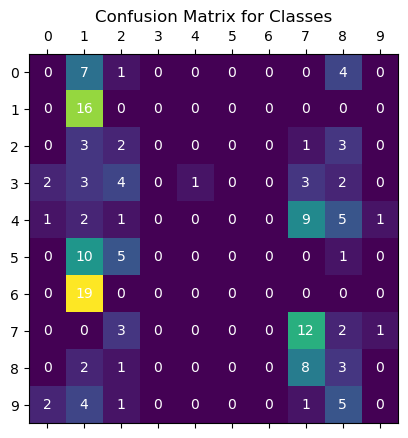

In [21]:
print('----------LOGREG----------')
fig = evaluate_predictions(Y_agg_true_unrolled, Y_pred_logreg, genre_list)

----------RANDOM_FOREST----------
Accuracy: 65.56%
Precision: 62.82%
Recall: 63.15%
F1: 0.6228678877382114


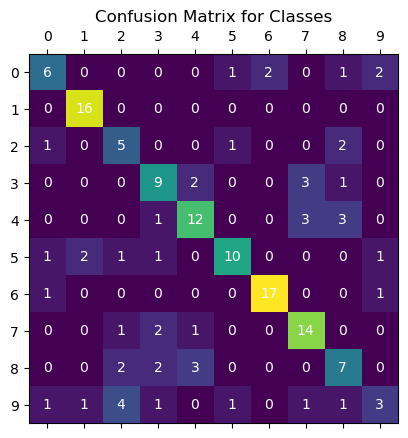

In [22]:
print('----------RANDOM_FOREST----------')
fig = evaluate_predictions(Y_agg_true_unrolled, Y_pred_rf, genre_list)

----------LSTM----------
Accuracy: 39.07%
Precision: 47.12%
Recall: 38.45%
F1: 0.3885272820961939


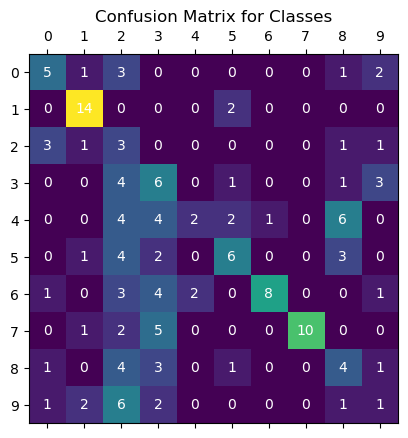

In [23]:
print('----------LSTM----------')
fig = evaluate_predictions(Y_mfcc_true, Y_pred_lstm, genre_list)

----------CNN----------
Accuracy: 69.54%
Precision: 68.91%
Recall: 67.17%
F1: 0.6708073909899468


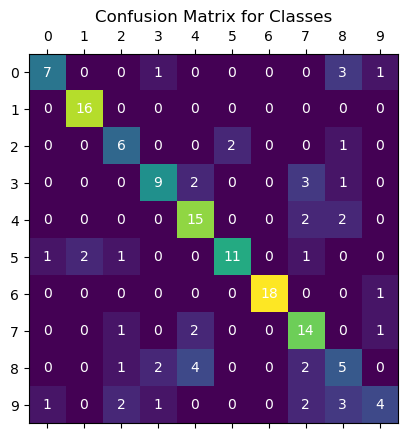

In [24]:
print('----------CNN----------')
fig = evaluate_predictions(Y_mfcc_true, Y_pred_cnn, genre_list)